In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import os

# **1. LOAD DATASET**

In [2]:
train_df = pd.read_csv("./dataset/combined_train_dataset.csv")
test_df = pd.read_csv("./dataset/Test_dataset.csv")

# **2. PREPROCESSING TRAIN DATASET**

## **2.1 DROP UNRELEVANT FEATURES**

In [3]:
train_df.dropna(subset=['Lithology_code'],inplace=True)
train_df = train_df.drop(columns=['DTS','SGR','ROPA','RMIC','RXO','DCAL','RSHA','file_name','filename','DEPTH_MD','Z_LOC','MUDWEIGHT','PEF'])

## **2.2 CLEANING DTC AND CONVERT TO NUMBER**

In [4]:
# Fungsi untuk menghapus 'val:' dan '[UNIT]' serta konversi ke float
def clean_value(value):
    if isinstance(value, str):  # Pastikan nilai adalah string
        # Hapus 'val:' jika ada
        if 'val:' in value:
            value = value.replace('val:', '').strip()
        # Hapus '[UNIT]' jika ada
        if '[UNIT]' in value:
            value = value.replace('[UNIT]', '').strip()
        # Coba konversi ke float
        try:
            return float(value)
        except ValueError:
            return value  # Kembalikan asli jika gagal konversi
    # Jika bukan string (misalnya sudah float), kembalikan apa adanya
    try:
        return float(value)
    except (ValueError, TypeError):
        return value  # Kembalikan asli jika gagal konversi

# Terapkan fungsi ke kolom DTC
train_df['DTC'] = train_df['DTC'].apply(clean_value)

## **2.3 FILL NAN LOCATION FEATURE WITH CDKTREE**

In [5]:
from scipy.spatial import cKDTree
import numpy as np

# Ensure X_LOC and Y_LOC have no missing values
train_df = train_df.dropna(subset=['X_LOC', 'Y_LOC'])

# Create KDTree using valid spatial coordinates
coords = train_df[['X_LOC', 'Y_LOC']].values
tree = cKDTree(coords)

# Find the 2 nearest neighbors (excluding itself)
_, idx = tree.query(coords, k=3)  # k=3 for backup if the first neighbor is missing

# Fill missing values using nearest neighbor
for col in ['NPHI', 'DTC', 'SP', 'GR', 'RHOB', 'CALI']:
    missing_mask = train_df[col].isna()  # Find missing values
    
    # Create an empty array to store filled values
    filled_values = train_df[col].values.copy()
    
    for i, is_missing in enumerate(missing_mask):
        if is_missing:
            # Check nearest neighbors
            for neighbor_idx in idx[i, 1:]:  # Skip self (idx[i, 0] is the same point)
                if not np.isnan(train_df.iloc[neighbor_idx][col]):  # Use first non-NaN neighbor
                    filled_values[i] = train_df.iloc[neighbor_idx][col]
                    break  # Stop after finding the first valid neighbor
    
    # Assign the new filled values
    train_df[col] = filled_values

## **2.4 CREATE CLUSTER FEATURE BY (X_LOC AND DEPT)**

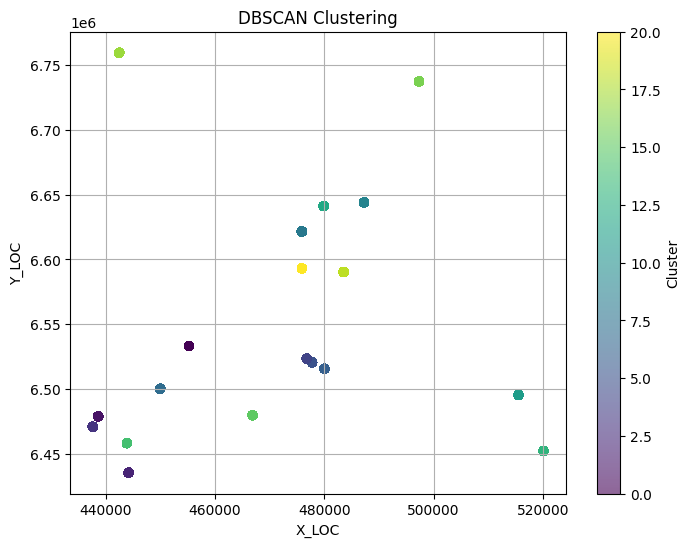

In [7]:
# Get indices of non-null X_LOC and Y_LOC values
valid_indices = train_df[['X_LOC', 'Y_LOC']].dropna().index

# Get X array for clustering
X = train_df.loc[valid_indices, ['X_LOC', 'Y_LOC']].astype(int).values

# Gunakan eps berdasarkan k-dist plot
dbscan = DBSCAN(eps=1, min_samples=5)
clusters = dbscan.fit_predict(X)

# Tambahkan hasil klaster ke train_df
train_df.loc[valid_indices, 'Cluster_DBSCAN'] = clusters

# Plot hasil clustering
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=clusters, cmap='viridis', marker='o', alpha=0.6)
plt.xlabel('X_LOC')
plt.ylabel('Y_LOC')
plt.title('DBSCAN Clustering')
plt.colorbar(label='Cluster')
plt.grid()
plt.show()

## **2.5 SPLIT DATASET BY CLUSTER**

In [9]:
clusters = train_df['Cluster_DBSCAN'].dropna().unique()  # Ambil semua cluster unik

# Buat dictionary untuk menyimpan DataFrame tiap cluster
cluster_dfs = {}

for cluster in clusters:
    cluster_dfs[cluster] = train_df[train_df['Cluster_DBSCAN'] == cluster].copy()

In [10]:
# Buat folder utama untuk menyimpan dataset per cluster
output_folder = 'dataset_cluster'
os.makedirs(output_folder, exist_ok=True)

# Iterasi setiap cluster dan simpan sebagai file CSV
for cluster, df in cluster_dfs.items():
    # Tentukan nama file dengan format "(nama_cluster)_dataset.csv"
    filename = f"{cluster}_dataset.csv"
    filepath = os.path.join(output_folder, filename)

    # Simpan DataFrame ke CSV
    df.to_csv(filepath, index=False)

## **2.6 FILL NAN BY ORDERING DEPT**

In [11]:
for cluster, df in cluster_dfs.items():
    # Urutkan data berdasarkan DEPT
    df = df.sort_values(by='DEPT')
    
    # Reset index untuk memudahkan akses
    df = df.reset_index(drop=True)
    
    # Ambil kolom numerik (kecuali Lithology_code)
    numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
    
    # Buat mask untuk melacak NaN awal
    nan_mask = df[numeric_cols].isna()
    
    # Forward Fill (ffill)
    for col in numeric_cols:
        condition_ffill = (df['Lithology_code'].shift(-1) == df['Lithology_code'])
        df[col] = df[col].where(~nan_mask[col] | ~condition_ffill, df[col].shift(-1))
    
    # Backward Fill (bfill)
    for col in numeric_cols:
        condition_bfill = (df['Lithology_code'].shift(1) == df['Lithology_code'])
        df[col] = df[col].where(~nan_mask[col] | ~condition_bfill, df[col].shift(1))
    
    # Logging: Hitung jumlah NaN yang diisi dengan setiap metode
    ffill_count = nan_mask.sum() - df[numeric_cols].isna().sum()
    bfill_count = nan_mask.sum() - df[numeric_cols].isna().sum() - ffill_count
    
    # Simpan kembali ke cluster_dfs
    cluster_dfs[cluster] = df

## **2.7 SPLIT BY CLASS ON EACH CLUSTER**

In [12]:
# Dictionary bertingkat untuk menyimpan data berdasarkan cluster dan lithology
cluster_lithology_dfs = {}

for cluster in cluster_dfs.keys():
    # Split lagi berdasarkan Lithology_code
    lithology_codes = cluster_dfs[cluster]['Lithology_code'].dropna().unique()
    
    # Dictionary dalam dictionary untuk Lithology_code per cluster
    cluster_lithology_dfs[cluster] = {}

    for litho in lithology_codes:
        cluster_lithology_dfs[cluster][litho] = cluster_dfs[cluster][cluster_dfs[cluster]['Lithology_code'] == litho].copy()

In [13]:
# Folder utama untuk menyimpan dataset per cluster dan lithology
main_folder = 'dataset_cluster_class'
os.makedirs(main_folder, exist_ok=True)

# Iterasi setiap cluster dan lithology
for cluster, lithology_dict in cluster_lithology_dfs.items():
    # Buat subfolder untuk cluster (misalnya "1", "2", dst.)
    cluster_folder = os.path.join(main_folder, str(cluster))
    os.makedirs(cluster_folder, exist_ok=True)
    
    for lithology_code, df in lithology_dict.items():
        # Tentukan nama file sesuai lithology_code
        filename = f"{lithology_code}.csv"
        filepath = os.path.join(cluster_folder, filename)

        # Simpan DataFrame ke CSV
        df.to_csv(filepath, index=False)

## **2.8 INTERPOLATE OUTLIER**

In [14]:
# Folder utama tempat dataset tersimpan
main_folder = 'dataset_cluster_class'

# Iterasi setiap subfolder (cluster)
for cluster_folder in os.listdir(main_folder):
    cluster_path = os.path.join(main_folder, cluster_folder)

    # Periksa apakah path adalah folder
    if os.path.isdir(cluster_path):
        # print(f"Opening folder: {cluster_folder}")

        # Iterasi setiap file dalam folder cluster
        for filename in os.listdir(cluster_path):
            file_path = os.path.join(cluster_path, filename)

            # Periksa apakah file adalah CSV
            if filename.endswith('.csv'):
                # print(f"Reading file: {filename}")

                # Buka file CSV sebagai DataFrame
                df = pd.read_csv(file_path)
                
                # Get list of outlier columns
                outlier_cols = [col for col in df.columns if "outlier" in col]
                
                if outlier_cols:  # If there are outlier columns
                    # Get corresponding feature columns (remove '_is_outlier' suffix)
                    feature_cols = [col.replace('_is_outlier', '') for col in outlier_cols]
                    
                    for feature, outlier_col in zip(feature_cols, outlier_cols):
                        if outlier_col in df.columns:
                            # Simpan mask NaN asli sebelum mengganti outlier dengan NaN
                            mask_nan_original = df[feature].isna()

                            # Mask untuk outlier
                            mask_outliers = df[outlier_col] == True  

                            # Ganti hanya outlier dengan NaN
                            df.loc[mask_outliers, feature] = None  

                            # Lakukan interpolasi
                            df[feature] = df[feature].interpolate(method='linear')

                            # Kembalikan NaN asli ke posisi semula
                            df.loc[mask_nan_original, feature] = None  
                    
                    # Save the updated DataFrame
                    df.to_csv(file_path, index=False)

# **3. FILL NAN VALUE**

## **3.1 FILL NAN VALUE WITH KNN IN EACH CLASS IN EACH CLUSTER** 

In [15]:
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# Definisi hubungan fitur untuk imputasi
imputation_dict = {
    'DTC': ['RHOB', 'NPHI', 'DEPT'],
    'RHOB': ['NPHI', 'DTC', 'DEPT'],
    'GR': ['DEPT'],
    'CALI': ['DEPT', 'BS'],
    'DRHO' : ['NPHI', 'DEPT'],
    'ROP' : ['NPHI','DEPT','CALI'],
    'NPHI': ['RHOB', 'DTC', 'DEPT','CALI'],
}

def impute_feature(df, target_feature, predictor_features):
    # Periksa apakah kolom target 100% NaN
    if df[target_feature].isna().sum() == len(df):
        print(f"Skipping {target_feature}: 100% NaN.")
        return df  # Kembalikan DataFrame tanpa perubahan
    
    # Periksa apakah semua kolom prediktor 100% NaN
    valid_predictors = [col for col in predictor_features if df[col].isna().sum() < len(df)]
    
    if len(valid_predictors) == 0:
        print(f"Skipping {target_feature}: All predictor columns are 100% NaN.")
        return df  # Kembalikan DataFrame tanpa perubahan
    
    # Jika target adalah CALI dan BS tersedia, gunakan regresi linear
    if (target_feature == 'CALI' and 'BS' in valid_predictors) or (target_feature == 'NPHI' and ['RHOB', 'DTC', 'DEPT','CALI'] in valid_predictors):
        print("Using Linear Regression for CALI imputations with BS...")
        
        # Pisahkan data menjadi yang memiliki nilai dan yang tidak
        known_data = df.dropna(subset=['CALI', 'BS'])
        unknown_data = df[df['CALI'].isna() & df['BS'].notna()]
        
        if not known_data.empty and not unknown_data.empty:
            # Latih model regresi
            model = LinearRegression()
            model.fit(known_data[['BS']], known_data['CALI'])
            
            # Prediksi nilai CALI yang hilang
            df.loc[df['CALI'].isna() & df['BS'].notna(), 'CALI'] = model.predict(unknown_data[['BS']])
    
    # Cek apakah masih ada NaN yang perlu diimputasi di target
    if df[target_feature].isna().sum() > 0:
        print(f"Imputing {target_feature} using {valid_predictors} with KNN...")

        # Ambil subset data dengan fitur prediktor valid dan target
        imputation_data = df[valid_predictors + [target_feature]].copy()

        # Standarisasi data
        scaler = StandardScaler()
        imputation_data_scaled = scaler.fit_transform(imputation_data)

        # Terapkan KNN Imputer
        imputer = KNNImputer(n_neighbors=5, weights='distance')
        imputed_data_scaled = imputer.fit_transform(imputation_data_scaled)

        # Kembalikan ke skala asli
        imputed_data = scaler.inverse_transform(imputed_data_scaled)
        imputed_df = pd.DataFrame(imputed_data, columns=valid_predictors + [target_feature], index=df.index)

        # Update DataFrame asli
        df[target_feature] = imputed_df[target_feature]
    else:
        print(f"No NaN values in {target_feature}. Skipping imputation.")
    
    return df

In [16]:
# Path ke folder utama yang berisi subfolder cluster
main_folder = 'dataset_cluster_class'  # Ganti dengan path folder utama Anda

# Iterasi setiap subfolder (cluster)
for cluster_folder in os.listdir(main_folder):
    cluster_path = os.path.join(main_folder, cluster_folder)

    # Periksa apakah path adalah folder
    if os.path.isdir(cluster_path):
        print(f"Processing folder: {cluster_folder}")

        # Iterasi setiap file dalam folder cluster
        for filename in os.listdir(cluster_path):
            file_path = os.path.join(cluster_path, filename)

            # Periksa apakah file adalah CSV
            if filename.endswith('.csv'):
                print(f"Reading file: {filename}")

                # Buka file CSV sebagai DataFrame
                df = pd.read_csv(file_path)

                # Lakukan imputasi untuk setiap fitur target
                for target_feature, predictor_features in imputation_dict.items():
                    # Pastikan semua fitur prediktor ada di DataFrame
                    if all(feature in df.columns for feature in predictor_features):
                        df = impute_feature(df, target_feature, predictor_features)
                    else:
                        print(f"Skipping imputation for {target_feature}: missing predictors in {filename}")

                # Simpan kembali file CSV yang telah diimputasi
                df.to_csv(file_path, index=False)
                print(f"Saved imputed file: {filename}")

Processing folder: 0.0
Reading file: 30000.0.csv
No NaN values in DTC. Skipping imputation.
No NaN values in RHOB. Skipping imputation.
No NaN values in GR. Skipping imputation.
Using Linear Regression for CALI imputations with BS...
No NaN values in CALI. Skipping imputation.
No NaN values in DRHO. Skipping imputation.
No NaN values in ROP. Skipping imputation.
No NaN values in NPHI. Skipping imputation.
Saved imputed file: 30000.0.csv
Reading file: 65000.0.csv
No NaN values in DTC. Skipping imputation.
No NaN values in RHOB. Skipping imputation.
No NaN values in GR. Skipping imputation.
Using Linear Regression for CALI imputations with BS...
No NaN values in CALI. Skipping imputation.
No NaN values in DRHO. Skipping imputation.
No NaN values in ROP. Skipping imputation.
No NaN values in NPHI. Skipping imputation.
Saved imputed file: 65000.0.csv
Reading file: 70000.0.csv
No NaN values in DTC. Skipping imputation.
No NaN values in RHOB. Skipping imputation.
No NaN values in GR. Skippin

## **3.2 JOIN EACH CLUSTER DATASET TO EACH CLASS DATASET** 

In [17]:
main_folder = "dataset_cluster_class"  # Ganti dengan nama folder utama jika berbeda
merged_df_list = []  # List untuk menyimpan DataFrame sebelum digabung

# Iterasi setiap subfolder (cluster)
for cluster_folder in os.listdir(main_folder):
    cluster_path = os.path.join(main_folder, cluster_folder)

    # Periksa apakah path adalah folder
    if os.path.isdir(cluster_path):
        # print(f"Processing folder: {cluster_folder}")

        # Iterasi setiap file dalam folder cluster
        for filename in os.listdir(cluster_path):
            file_path = os.path.join(cluster_path, filename)

            # Periksa apakah file adalah CSV
            if filename.endswith('.csv'):
                # print(f"Reading file: {filename}")

                # Buka file CSV sebagai DataFrame
                df = pd.read_csv(file_path)

                # Tambahkan ke daftar DataFrame
                merged_df_list.append(df)

# Gabungkan semua DataFrame dalam daftar
if merged_df_list:
    merged_df = pd.concat(merged_df_list, ignore_index=True)

    # Simpan sebagai satu file CSV gabungan
    merged_csv_path = os.path.join(main_folder, "merged_dataset.csv")
    merged_df.to_csv(merged_csv_path, index=False)
    print(f"Saved merged dataset: {merged_csv_path}")
else:
    print("No CSV files found to merge.")

merged_df = merged_df[[i for i in merged_df.columns if "outlier" not in i]]

lithology_code = merged_df['Lithology_code'].dropna().unique()  # Ambil semua cluster unik

# Buat dictionary untuk menyimpan DataFrame tiap cluster
lithology_df = {}

for code in lithology_code:
    lithology_df[code] = merged_df[merged_df['Lithology_code'] == code].copy()
    
# Buat folder utama untuk menyimpan dataset per cluster
output_folder = 'dataset_lithology'
os.makedirs(output_folder, exist_ok=True)

# Iterasi setiap cluster dan simpan sebagai file CSV
for code, df in lithology_df.items():
    # Tentukan nama file dengan format "(nama_code)_dataset.csv"
    filename = f"{code}_dataset.csv"
    filepath = os.path.join(output_folder, filename)

    # Simpan DataFrame ke CSV
    df.to_csv(filepath, index=False)

Saved merged dataset: dataset_cluster_class\merged_dataset.csv


## **3.3 FILL NAN VALUE WITH KNN IN EACH CLASS** 

In [18]:
main_folder = 'dataset_lithology'

# Iterate through files in the main folder
for filename in os.listdir(main_folder):
    file_path = os.path.join(main_folder, filename)
    
    # Check if file is CSV
    if filename.endswith('.csv'):
        print(f"Reading file: {filename}")

        # Read CSV as DataFrame
        df = pd.read_csv(file_path)

        # Perform imputation for each target feature
        for target_feature, predictor_features in imputation_dict.items():
            # Make sure all predictor features exist in DataFrame
            if all(feature in df.columns for feature in predictor_features):
                df = impute_feature(df, target_feature, predictor_features)
            else:
                print(f"Skipping imputation for {target_feature}: missing predictors in {filename}")

        # Save back the imputed CSV file
        df.to_csv(file_path, index=False)
        print(f"Saved imputed file: {filename}")

Reading file: 30000.0_dataset.csv
No NaN values in DTC. Skipping imputation.
Imputing RHOB using ['NPHI', 'DTC', 'DEPT'] with KNN...
No NaN values in GR. Skipping imputation.
Using Linear Regression for CALI imputations with BS...
No NaN values in CALI. Skipping imputation.
Imputing DRHO using ['NPHI', 'DEPT'] with KNN...
Imputing ROP using ['NPHI', 'DEPT', 'CALI'] with KNN...
Imputing NPHI using ['RHOB', 'DTC', 'DEPT', 'CALI'] with KNN...
Saved imputed file: 30000.0_dataset.csv
Reading file: 65000.0_dataset.csv
No NaN values in DTC. Skipping imputation.
Imputing RHOB using ['NPHI', 'DTC', 'DEPT'] with KNN...
No NaN values in GR. Skipping imputation.
Using Linear Regression for CALI imputations with BS...
No NaN values in CALI. Skipping imputation.
Imputing DRHO using ['NPHI', 'DEPT'] with KNN...
Imputing ROP using ['NPHI', 'DEPT', 'CALI'] with KNN...
Imputing NPHI using ['RHOB', 'DTC', 'DEPT', 'CALI'] with KNN...
Saved imputed file: 65000.0_dataset.csv
Reading file: 65030.0_dataset.cs

In [19]:
main_folder = "dataset_lithology"  # Main folder containing lithology CSV files
merged_df_list = []  # List to store DataFrames before merging

# Iterate through files in the main folder
for filename in os.listdir(main_folder):
    file_path = os.path.join(main_folder, filename)

    # Check if file is CSV
    if filename.endswith('.csv'):
        # Read CSV as DataFrame
        df = pd.read_csv(file_path)
        merged_df_list.append(df)

# Merge all DataFrames in the list
if merged_df_list:
    merged_df = pd.concat(merged_df_list, ignore_index=True)

    # Save as one merged CSV file
    merged_csv_path = "./dataset/cleaned_dataset.csv"
    merged_df.to_csv(merged_csv_path, index=False)
    merged_df.to_csv("./dataset/cleaned_dataset.csv", index=False)
    print(f"Saved merged dataset: {merged_csv_path}")
else:
    print("No CSV files found to merge.")
merged_df.to_csv(merged_csv_path,index=False)

Saved merged dataset: ./dataset/cleaned_dataset.csv


## **3.4 CLEANING ALL NAN VALUE IN ALL DATASET**

In [21]:
# Lakukan imputasi untuk setiap fitur target
for target_feature, predictor_features in imputation_dict.items():
    # Pastikan semua fitur prediktor ada di DataFrame
    if all(feature in df.columns for feature in predictor_features):
        cleaned_dataset = impute_feature(merged_df, target_feature, predictor_features)
    else:
        print(f"Skipping imputation for {target_feature}: missing predictors in {filename}")

No NaN values in DTC. Skipping imputation.
No NaN values in RHOB. Skipping imputation.
No NaN values in GR. Skipping imputation.
Using Linear Regression for CALI imputations with BS...
No NaN values in CALI. Skipping imputation.
No NaN values in DRHO. Skipping imputation.
No NaN values in ROP. Skipping imputation.
No NaN values in NPHI. Skipping imputation.


# **4. MODELLING**

In [26]:
import pandas as pd

training_dataset = pd.read_csv("./dataset/cleaned_dataset.csv")
training_dataset = training_dataset[['X_LOC','Y_LOC','DEPT','NPHI','DTC','RHOB','GR','CALI','Lithology_code']]
training_dataset.head()

,X_LOC,Y_LOC,DEPT,NPHI,DTC,RHOB,GR,CALI,Lithology_code
0,455221.34375,6533321.5,2712.460002,0.218318,71.954613,2.257217,58.311520,14.666450,30000.0
1,455221.34375,6533321.5,2726.596002,0.085455,59.167652,2.548615,88.030212,12.509160,30000.0
2,455221.34375,6533321.5,2726.748002,0.114017,60.975471,2.518298,86.302811,12.547709,30000.0
3,455221.34375,6533321.5,2726.900002,0.147875,62.972198,2.492360,79.648369,12.620093,30000.0
4,455221.34375,6533321.5,2727.052002,0.180865,64.157539,2.470284,67.485962,12.537360,30000.0


In [27]:
from pycaret.classification import *
import pandas as pd
from sklearn.model_selection import train_test_split

# Load dataset (ganti dengan dataset yang sesuai)
data = training_dataset.copy()

# Pisahkan fitur dan target
target_column = "Lithology_code"  # Ganti dengan nama kolom target

# Split dataset into train and test
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Setup PyCaret
clf = setup(train_data, target=target_column, normalize=True, session_id=42)

# Compare models and find the best one
best_model = compare_models()

,Description,Value
0,Session id,42
1,Target,Lithology_code
2,Target type,Multiclass
3,Target mapping,"30000.0: 0, 65000.0: 1, 65030.0: 2, 70000.0: 3, 70032.0: 4, 74000.0: 5, 80000.0: 6, 86000.0: 7, 88000.0: 8, 90000.0: 9, 93000.0: 10, 99000.0: 11"
4,Original data shape,"(203789, 9)"
5,Transformed data shape,"(203789, 9)"
6,Transformed train set shape,"(142652, 9)"
7,Transformed test set shape,"(61137, 9)"
8,Numeric features,8
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.9692,0.9981,0.9692,0.9690,0.9689,0.9498,0.9499,1.4340
rf,Random Forest Classifier,0.9656,0.9976,0.9656,0.9653,0.9651,0.9438,0.9439,4.5440
xgboost,Extreme Gradient Boosting,0.9557,0.9962,0.9557,0.9552,0.9551,0.9277,0.9279,3.9590
dt,Decision Tree Classifier,0.9396,0.9537,0.9396,0.9397,0.9396,0.9022,0.9022,0.3700
knn,K Neighbors Classifier,0.9296,0.9807,0.9296,0.9284,0.9284,0.8847,0.8850,0.5870
gbc,Gradient Boosting Classifier,0.9029,0.0000,0.9029,0.9017,0.8978,0.8370,0.8396,110.9310
lightgbm,Light Gradient Boosting Machine,0.8572,0.8929,0.8572,0.8651,0.8577,0.7648,0.7663,8.5940
qda,Quadratic Discriminant Analysis,0.7181,0.0000,0.7181,0.7023,0.7009,0.5214,0.5259,0.0730
lda,Linear Discriminant Analysis,0.7032,0.0000,0.7032,0.6638,0.6522,0.4527,0.4757,0.0890
lr,Logistic Regression,0.7002,0.0000,0.7002,0.6558,0.6471,0.4403,0.4643,1.8780


# **5. EVALUATION AND TUNNING MODEL**

In [ ]:
# Hyperparameter tuning
tuned_model = tune_model(best_model)

# Evaluate tuned model
evaluate_model(tuned_model)

# Finalize the model (optional, jika ingin digunakan untuk prediksi lebih lanjut)
final_model = finalize_model(tuned_model)

# Predict on test data
predictions = predict_model(final_model, data=test_data)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7976,0.9595,0.7976,0.8059,0.7600,0.6223,0.6541
1,0.7974,0.9587,0.7974,0.8054,0.7598,0.6219,0.6535
2,0.7982,0.9571,0.7982,0.8054,0.7634,0.6249,0.6548
3,0.7956,0.9580,0.7956,0.8032,0.7586,0.6187,0.6500
4,0.7959,0.9579,0.7959,0.8029,0.7576,0.6205,0.6504
5,0.7938,0.9571,0.7938,0.8016,0.7550,0.6154,0.6464
6,0.7948,0.9580,0.7948,0.8026,0.7560,0.6175,0.6482
7,0.7890,0.9554,0.7890,0.7987,0.7481,0.6052,0.6376
8,0.7970,0.9587,0.7970,0.8037,0.7619,0.6223,0.6526


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.9745,0.9989,0.9745,0.9744,0.9743,0.9584,0.9585


               X_LOC      Y_LOC         DEPT      NPHI         DTC      RHOB  \
111878  442439.71875  6759337.0  3628.305908  0.267848   78.389526  2.675912   
78161   520153.18750  6452287.5  2161.697021  0.424427  123.719910  2.290416   
76220   520153.18750  6452287.5  1812.704956  0.389822  115.962715  2.316001   
90584   497352.43750  6737314.5  1613.750000  0.494470  146.163330  2.112000   
16658   442442.84375  6759398.5   887.442017  0.324526  151.318893  2.186882   
...              ...        ...          ...       ...         ...       ...   
33476   449950.62500  6500259.0   768.489624  0.452436  149.884308  2.049571   
87538   497358.62500  6737310.5   633.349976  0.391190  134.840363  2.105914   
107104  442427.75000  6759350.0  2691.530029  0.286219  106.284653  2.514788   
228522  487274.43750  6643962.5  2641.112061  0.143584   60.896545  2.615238   
223073  477771.87500  6520630.0  1799.034790  0.195466   89.917854  2.472843   

                 GR       CALI  Litholo

In [ ]:
predictions

In [ ]:
# Save the final model
save_model(final_model, "final_lithology_model_2")

print("Model saved successfully!")

---

# **TEST DATASET**